In [2]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from pop_models import full, compact, agpm
reload(full)
reload(compact)
reload(agpm)

from wfsc_1dm import iefc, pwp, utils

import misc_funs as misc

pupil_diam = 10.2*u.mm
wavelength_c = 750e-9*u.m

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)

lyot_stop_physical = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm)
lyot_stop_compact = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm * 500/350)

hdr = fits.getheader('wfe_on_axis.fits')
ote_wfe = poppy.FITSOpticalElement(opd='wfe_on_axis.fits', opdunits='meters',
                                   pixelscale=pupil_diam.to_value(u.m)/hdr['NAXIS1'])
misc.imshow1(ote_wfe.opd, 'WFE from Telescope Optics', pxscl=ote_wfe.pixelscale.to(u.mm/u.pix))


wfe = fits.getdata('pupil-data/post_fpm_pupil_wfe.fits')
wfe_pxscl = fits.getheader('pupil-data/post_fpm_pupil_wfe.fits')['PIXELSCL'] * u.m/u.pix
wfe = poppy.ArrayOpticalElement(transmission=wfe[0], 
                                opd=wfe[1]*wavelength_c.to_value(u.m)/(2*np.pi),
                                pixelscale=wfe_pxscl,
                               )
misc.imshow2(wfe.amplitude, wfe.opd, pxscl=wfe.pixelscale)

FileNotFoundError: [Errno 2] No such file or directory: 'wfe_on_axis.fits'

In [2]:
reload(full)
reload(compact)

reload(agpm)
vortexf = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)
vortexc = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)

fc = full.CORO()

fc.npix = 128
fc.oversample = 16
fc.npsf = 128

fc.use_opds = True
fc.OTEWFE = ote_wfe
fc.FPM = vortexf
fc.LYOT = lyot_stop_physical

cc = compact.CORO()

cc.npix = 128
cc.oversample = 16
cc.npsf = 128

cc.RETRIEVED = wfe 
cc.FPM = vortexc
cc.LYOT = lyot_stop_compact

im_full = fc.snap()

im_comp = cc.snap()

misc.imshow2(im_full, im_comp, 'Full Model Image', 'Compact Model Image', lognorm=True,
             pxscl1=fc.psf_pixelscale_lamD, pxscl2=cc.psf_pixelscale_lamD)

TypeError: imshow2() got an unexpected keyword argument 'lognorm'

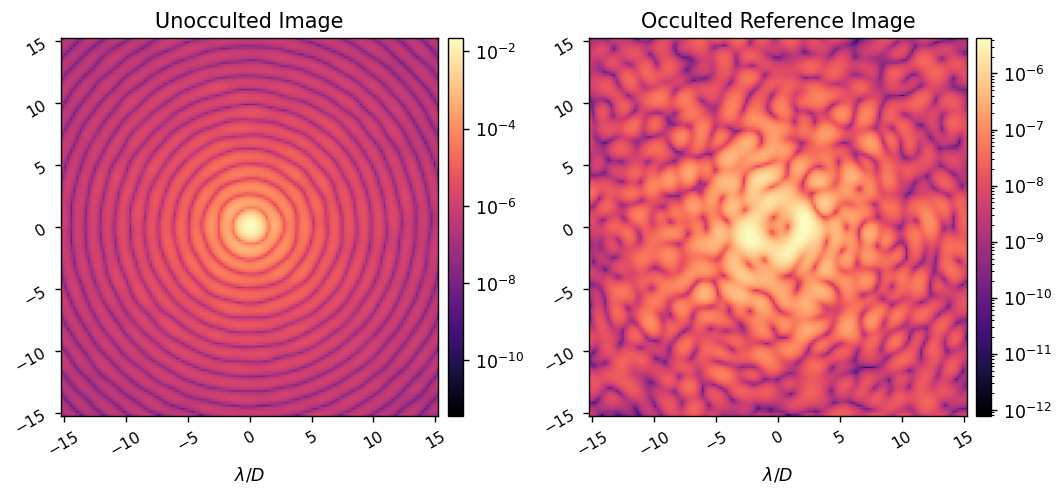

In [30]:
reload(full)

fc.FPM = None
ref_im_unocc = fc.snap()

fc.FPM = vortexf
ref_im = fc.snap()

misc.imshow2(ref_im_unocc, ref_im, 'Unocculted Image', 'Occulted Reference Image',
             lognorm=True,
             pxscl=fc.psf_pixelscale_lamD, xlabel='$\lambda/D$')

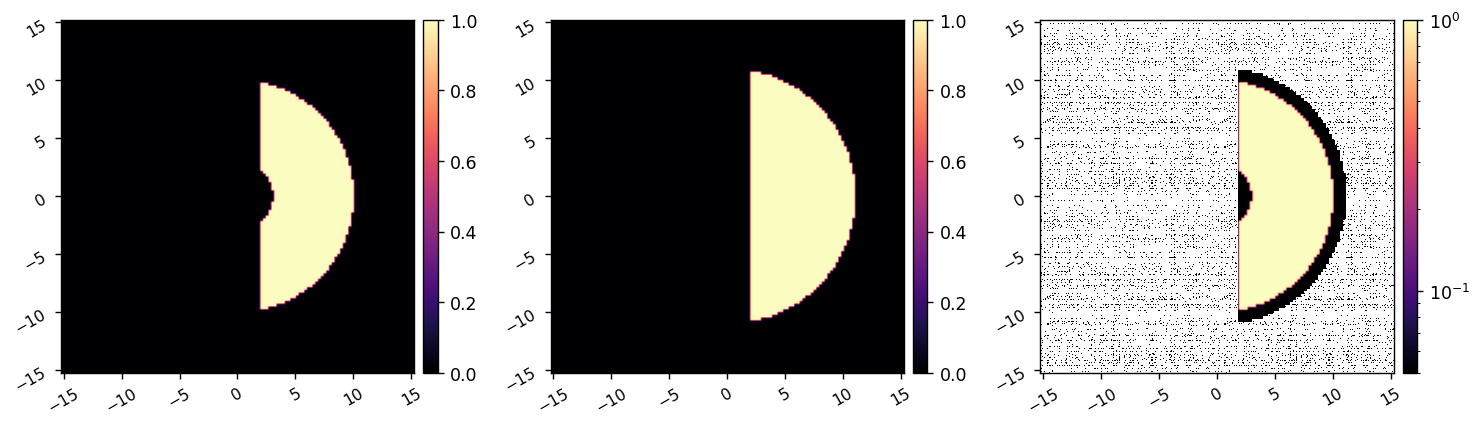

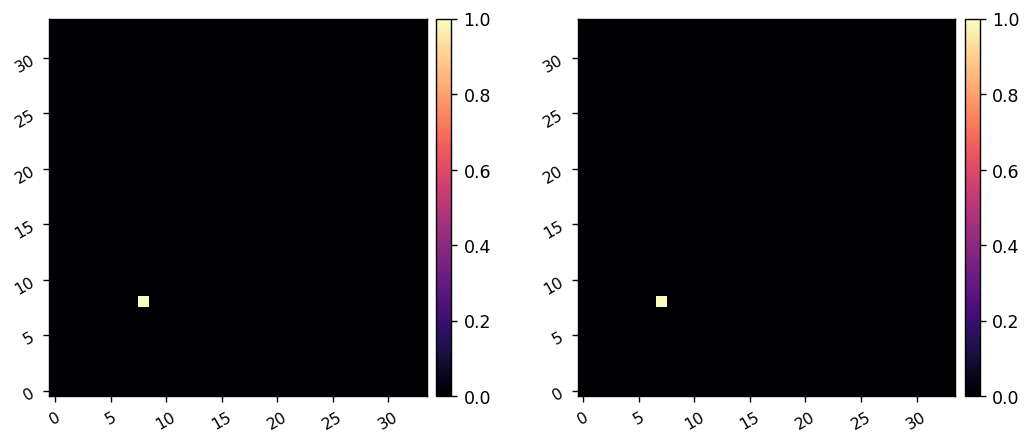

In [31]:
npsf = cc.npsf
Nact = cc.Nact
xfp = (np.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*cc.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 2
iwa = 3
owa = 10
rot = 0

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
#     'direction' : '+x',
    'rotation':rot,
    'full':False
}
dh_mask = utils.create_annular_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-1,
    'outer_radius' : owa+1,
    'edge_position' : edge-0.2,
#     'direction' : '+x',
    'rotation':rot,
    'full':False
}
control_mask = utils.create_annular_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.95

weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask 
misc.imshow3(dh_mask.reshape(npsf,npsf),
               control_mask.reshape(npsf,npsf), 
               weights.reshape(npsf,npsf),
               lognorm3=True,
               pxscl1=cc.psf_pixelscale_lamD, pxscl2=cc.psf_pixelscale_lamD, pxscl3=cc.psf_pixelscale_lamD)

reload(utils)
probe_amp = 5e-8
# probe_modes = utils.create_probe_poke_modes(Nact, xinds=[Nact//3, Nact//2, 2*Nact//3], yinds=[2*Nact//3, Nact//3, 2*Nact//3],display=True)
probe_modes = utils.create_probe_poke_modes(Nact, xinds=[Nact//4, Nact//4-1], yinds=[Nact//4, Nact//4], display=True)

In [14]:
control_mask.shape

(16384,)

(436, 1156) (218, 2)


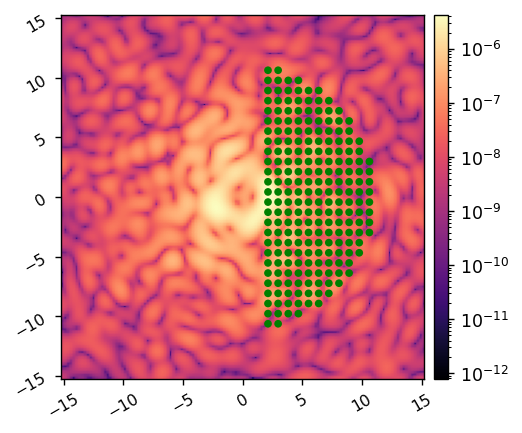

In [32]:
reload(utils)
fourier_modes, fs = utils.select_fourier_modes(cc, control_mask*(xf>0).flatten(), fourier_sampling=0.85) 
nf = fourier_modes.shape[0]
print(fourier_modes.shape, fs.shape)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
misc.imshow1(ref_im, lognorm=True, pxscl=cc.psf_pixelscale_lamD, patches=patches)

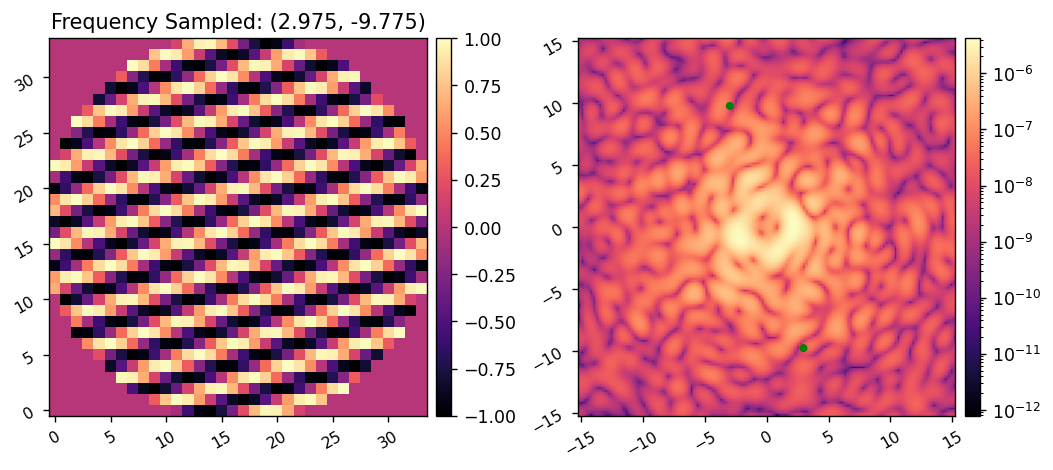

In [33]:
import time
for i in range(fourier_modes.shape[0]//2):
    try:
        misc.imshow2(fourier_modes[i].reshape(Nact,Nact), ref_im, 
                       'Frequency Sampled: ({:.3f}, {:.3f})'.format(fs[i][0], fs[i][1]),
                       lognorm2=True,
                       pxscl2=cc.psf_pixelscale_lamD, 
                       patches2=[Circle(fs[i], 0.25, fill=True, color='g'),
                                 Circle(-fs[i], 0.25, fill=True, color='g')])
        clear_output(wait=True)
        time.sleep(0.25)
    except KeyboardInterrupt:
        break

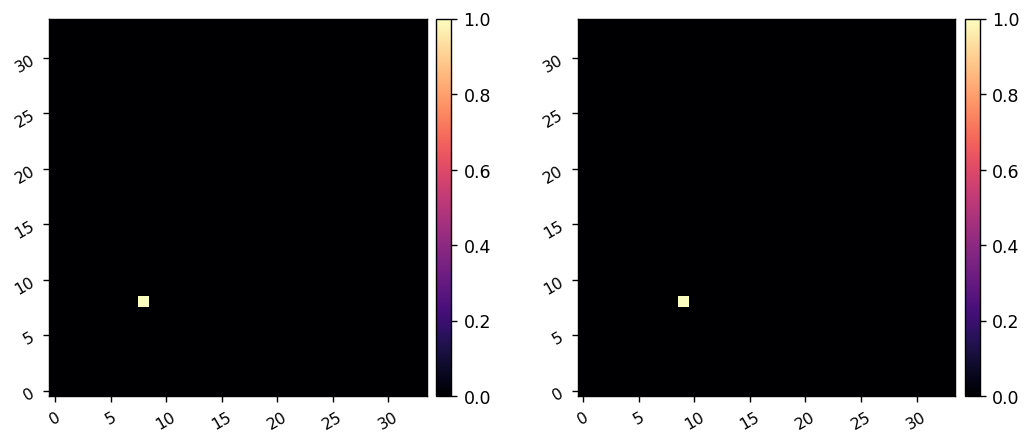

In [35]:
reload(utils)
probe_modes = utils.create_probe_poke_modes(Nact, xinds=[Nact//4, Nact//4+1], yinds=[Nact//4, Nact//4], display=True)
# probe_modes = utils.create_fourier_probes(calib_modes, display_probes=True)

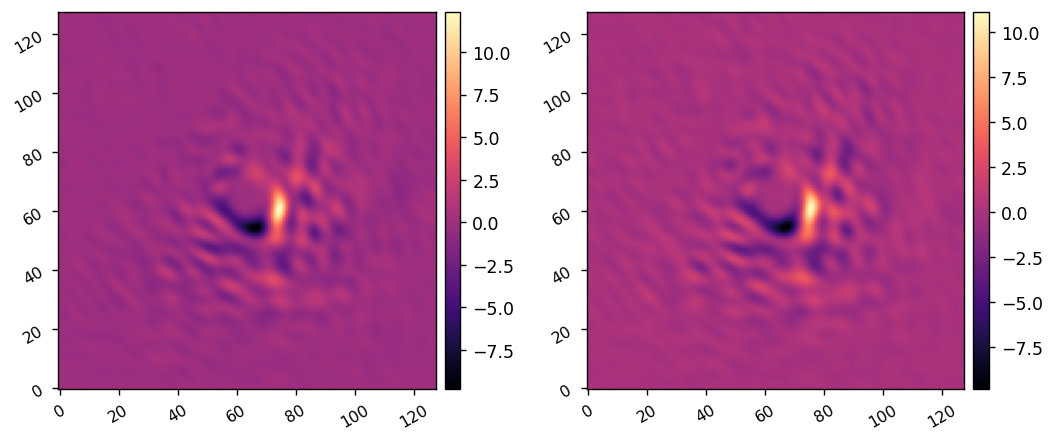

In [38]:
reload(iefc)
cc.reset_dm()
cc.texp = 1
differential_images, single_images = iefc.take_measurement(cc, 
                                                           probe_modes, probe_amp, 
                                                           return_all=True, display=True)

In [41]:
probe_amp = 3e-8
calib_amp = 5e-9

cc.reset_dm()
cc.texp = 1
response_cube, calibration_cube = iefc.calibrate(cc, 
                                                 probe_amp, probe_modes, 
                                                 calib_amp, fourier_modes, 
                                                 start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 436 in 0.965s
	Calibrated mode 2 / 436 in 1.667s
	Calibrated mode 3 / 436 in 2.381s
	Calibrated mode 4 / 436 in 3.074s
	Calibrated mode 5 / 436 in 3.753s
	Calibrated mode 6 / 436 in 4.415s
	Calibrated mode 7 / 436 in 5.141s
	Calibrated mode 8 / 436 in 5.825s
	Calibrated mode 9 / 436 in 6.504s
	Calibrated mode 10 / 436 in 7.193s
	Calibrated mode 11 / 436 in 7.931s
	Calibrated mode 12 / 436 in 8.685s
	Calibrated mode 13 / 436 in 9.434s
	Calibrated mode 14 / 436 in 10.155s
	Calibrated mode 15 / 436 in 10.866s
	Calibrated mode 16 / 436 in 11.569s
	Calibrated mode 17 / 436 in 12.245s
	Calibrated mode 18 / 436 in 12.931s
	Calibrated mode 19 / 436 in 13.632s
	Calibrated mode 20 / 436 in 14.331s
	Calibrated mode 21 / 436 in 15.043s
	Calibrated mode 22 / 436 in 15.736s
	Calibrated mode 23 / 436 in 16.400s
	Calibrated mode 24 / 436 in 17.090s
	Calibrated mode 25 / 436 in 17.764s
	Calibrated mode 26 / 436 in 18.483s
	Calibrated mode 27 / 436 in 19.217s
	C

	Calibrated mode 218 / 436 in 157.030s
	Calibrated mode 219 / 436 in 157.741s
	Calibrated mode 220 / 436 in 158.428s
	Calibrated mode 221 / 436 in 159.127s
	Calibrated mode 222 / 436 in 159.825s
	Calibrated mode 223 / 436 in 160.530s
	Calibrated mode 224 / 436 in 161.233s
	Calibrated mode 225 / 436 in 161.940s
	Calibrated mode 226 / 436 in 162.651s
	Calibrated mode 227 / 436 in 163.355s
	Calibrated mode 228 / 436 in 164.048s
	Calibrated mode 229 / 436 in 164.755s
	Calibrated mode 230 / 436 in 165.482s
	Calibrated mode 231 / 436 in 166.171s
	Calibrated mode 232 / 436 in 166.862s
	Calibrated mode 233 / 436 in 167.544s
	Calibrated mode 234 / 436 in 168.233s
	Calibrated mode 235 / 436 in 168.956s
	Calibrated mode 236 / 436 in 169.743s
	Calibrated mode 237 / 436 in 170.440s
	Calibrated mode 238 / 436 in 171.142s
	Calibrated mode 239 / 436 in 171.843s
	Calibrated mode 240 / 436 in 172.541s
	Calibrated mode 241 / 436 in 173.257s
	Calibrated mode 242 / 436 in 173.964s
	Calibrated mode 243 / 43

	Calibrated mode 429 / 436 in 306.926s
	Calibrated mode 430 / 436 in 307.586s
	Calibrated mode 431 / 436 in 308.271s
	Calibrated mode 432 / 436 in 308.964s
	Calibrated mode 433 / 436 in 309.647s
	Calibrated mode 434 / 436 in 310.305s
	Calibrated mode 435 / 436 in 310.928s
	Calibrated mode 436 / 436 in 311.625s
Calibration complete.


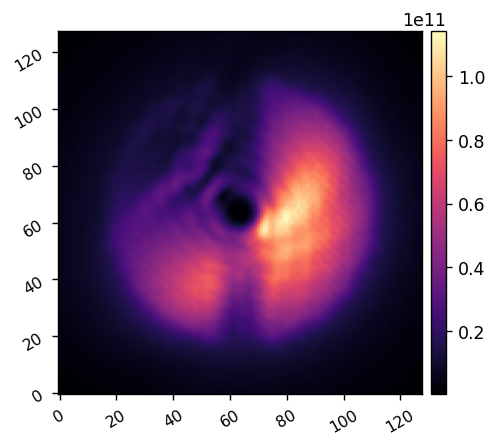

In [43]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
misc.imshow1(response_sum.reshape(npsf, npsf))

In [44]:
misc.save_fits('jacobians/response_20230406.fits', data=response_cube)

Saved data to:  jacobians/response_20230406.fits


In [45]:
control_matrix = iefc.construct_control_matrix(response_cube, 
                                               weights.flatten(), 
                                               rcond=1e-2, 
                                               nprobes=probe_modes.shape[0], pca_modes=None)
display(response_cube.shape, control_matrix.shape)

reg_fun = iefc.construct_control_matrix
reg_conds = np.array([[0, 10, 15, 20],
                      [1e-1, 1e-3, 1e-1, 1e-2]])

Using Weighted Least Squares 


(436, 2, 16384)

(436, 5236)

Running I-EFC...
	Closed-loop iteration 1 / 30
	Computing EFC matrix via construct_control_matrix with condition value 1.00e-01
Using Weighted Least Squares 


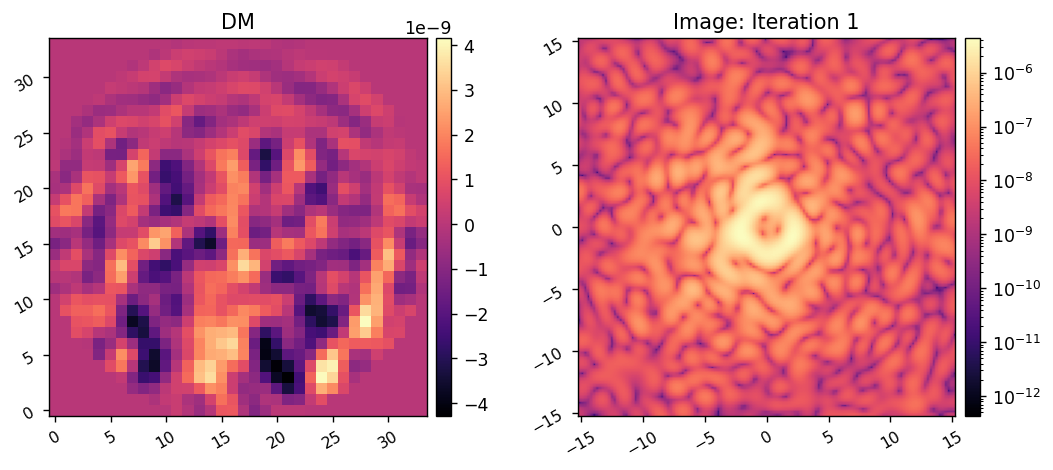

	Closed-loop iteration 2 / 30


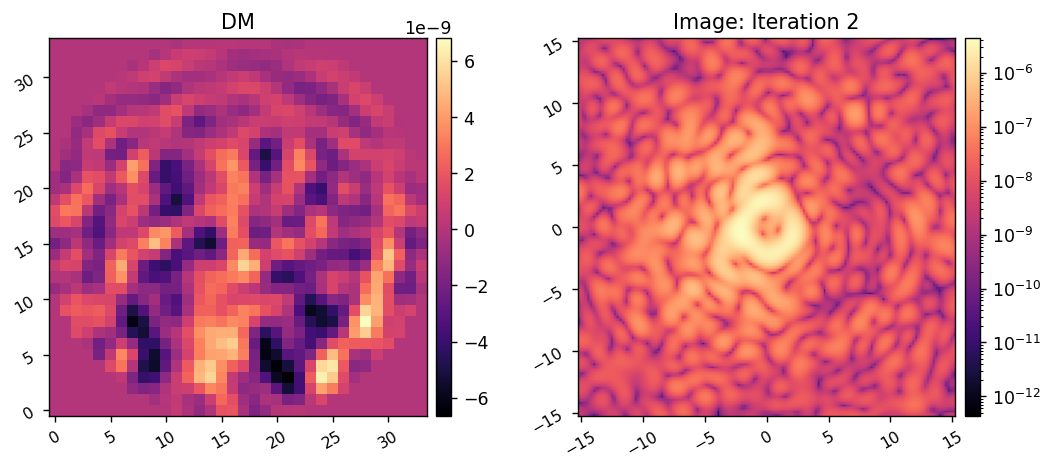

	Closed-loop iteration 3 / 30


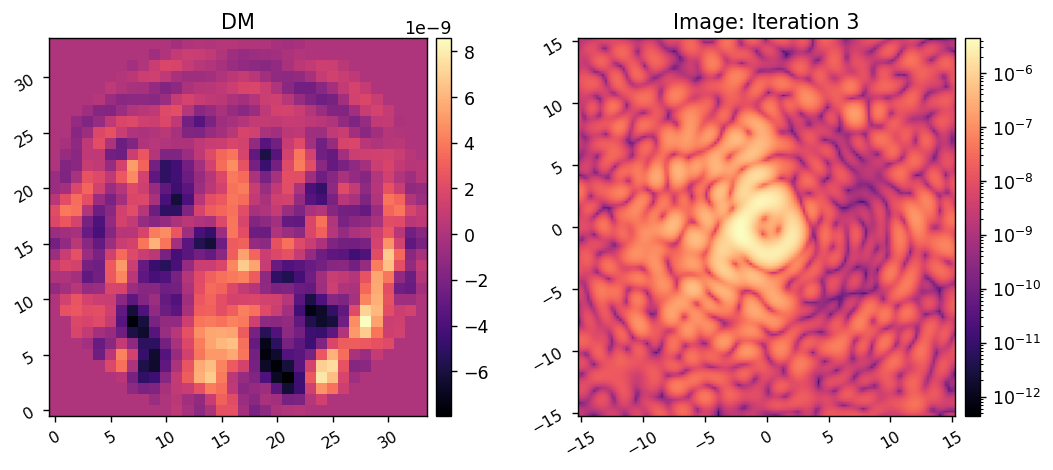

	Closed-loop iteration 4 / 30


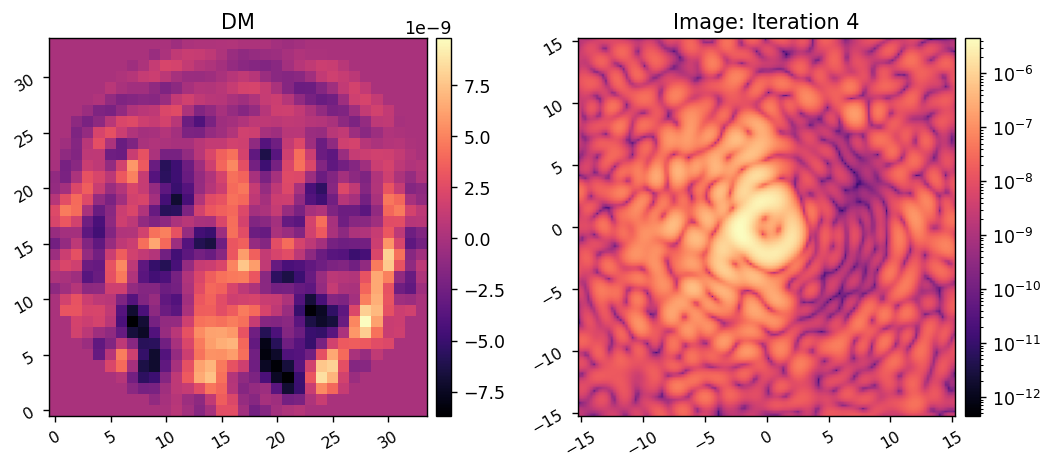

	Closed-loop iteration 5 / 30


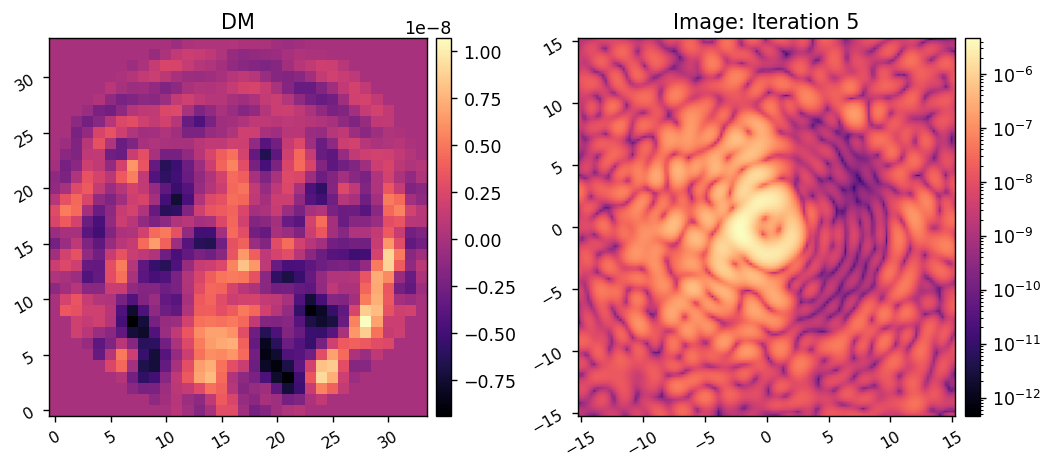

	Closed-loop iteration 6 / 30


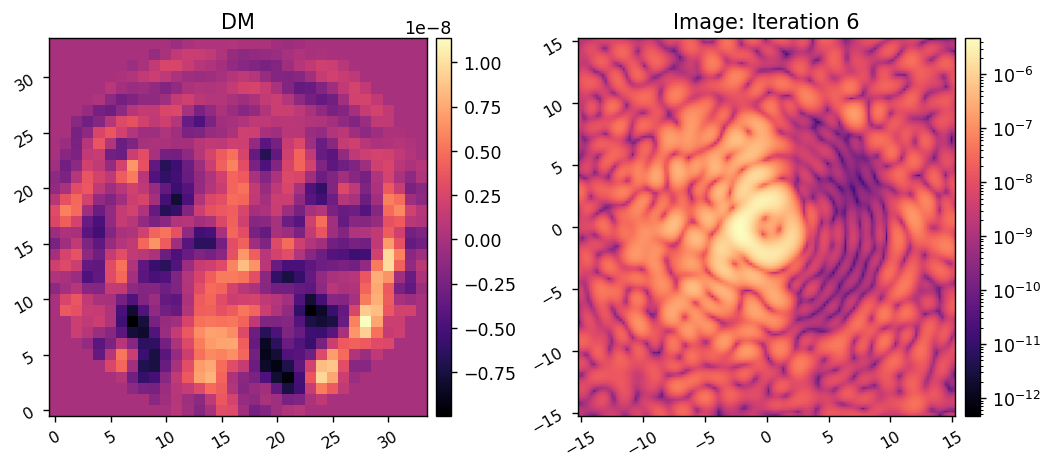

	Closed-loop iteration 7 / 30


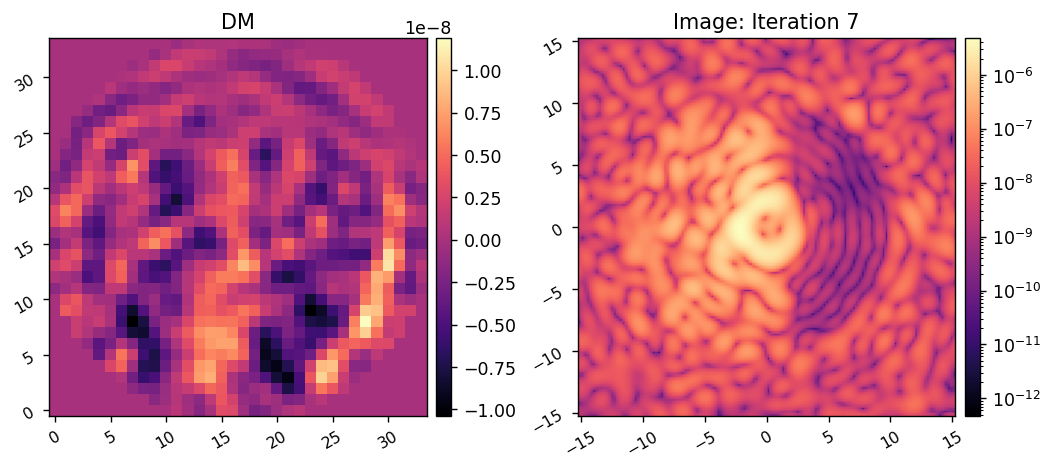

	Closed-loop iteration 8 / 30


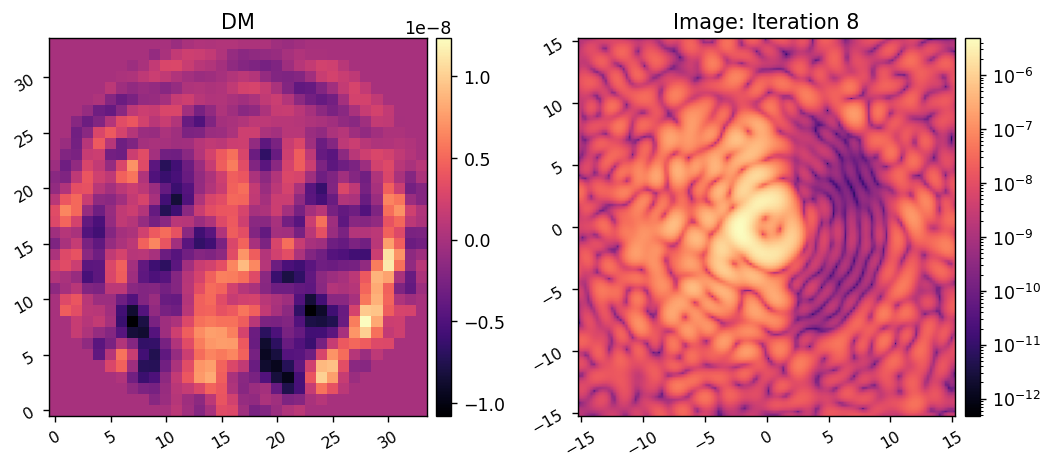

	Closed-loop iteration 9 / 30


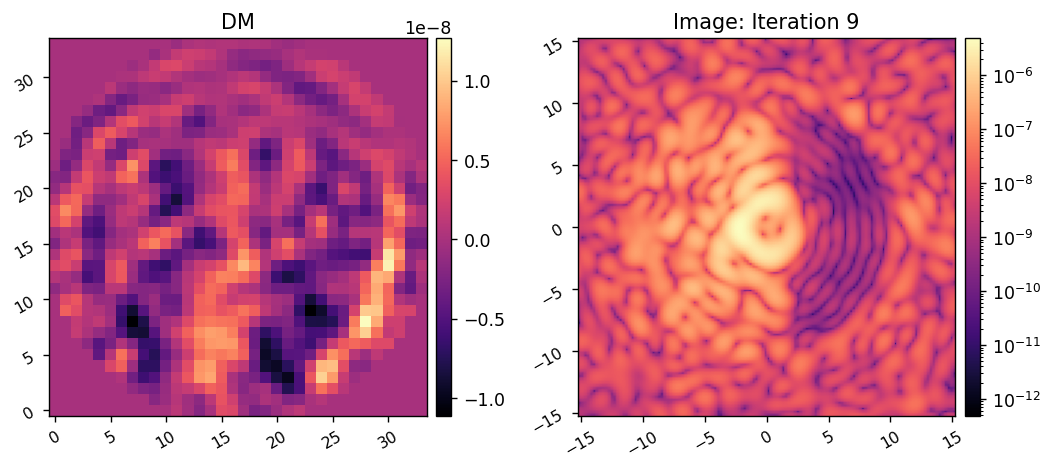

	Closed-loop iteration 10 / 30


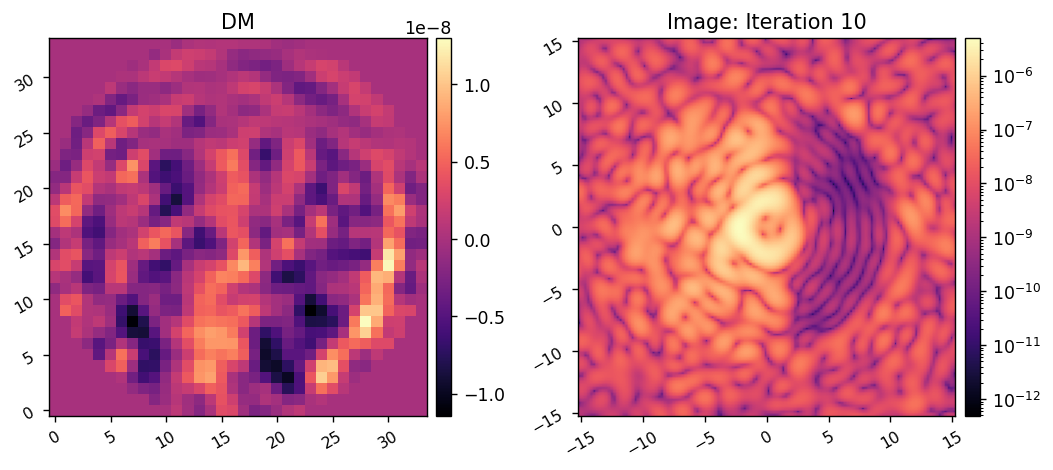

	Closed-loop iteration 11 / 30
	Computing EFC matrix via construct_control_matrix with condition value 1.00e-03
Using Weighted Least Squares 


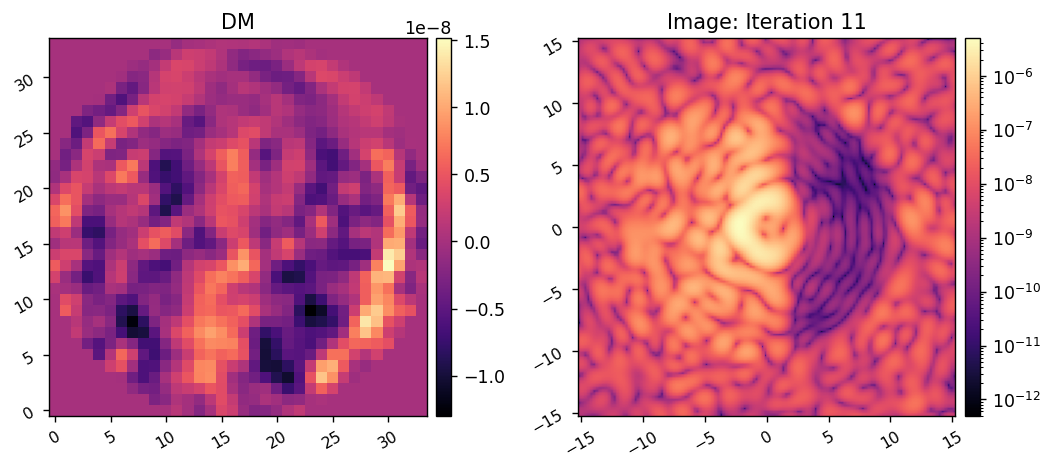

	Closed-loop iteration 12 / 30


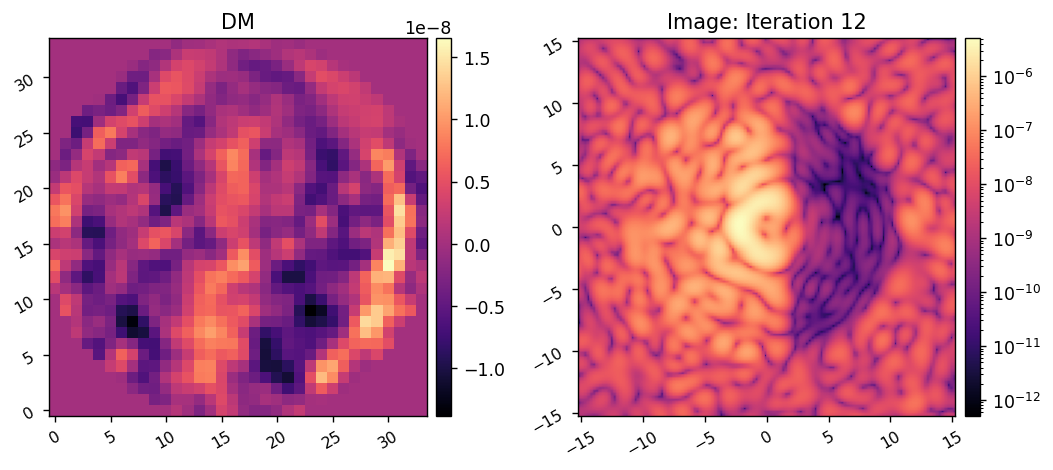

	Closed-loop iteration 13 / 30


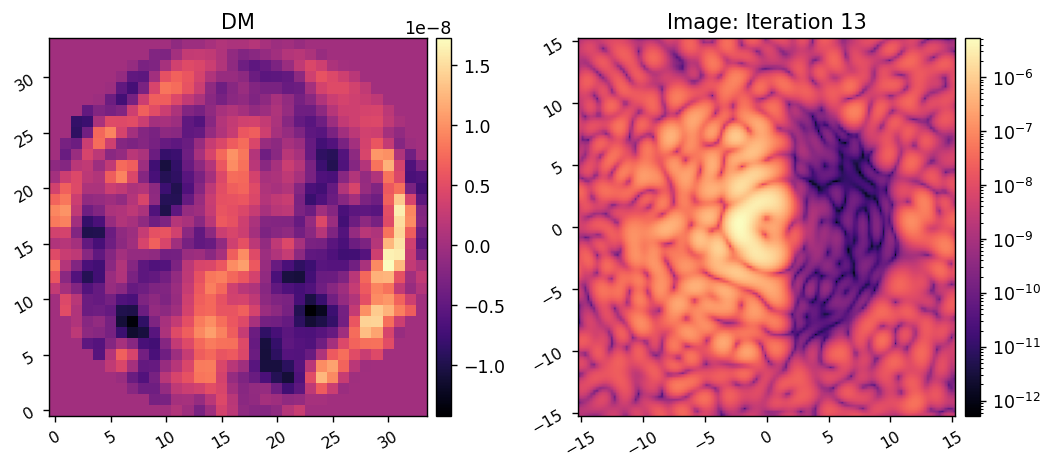

	Closed-loop iteration 14 / 30


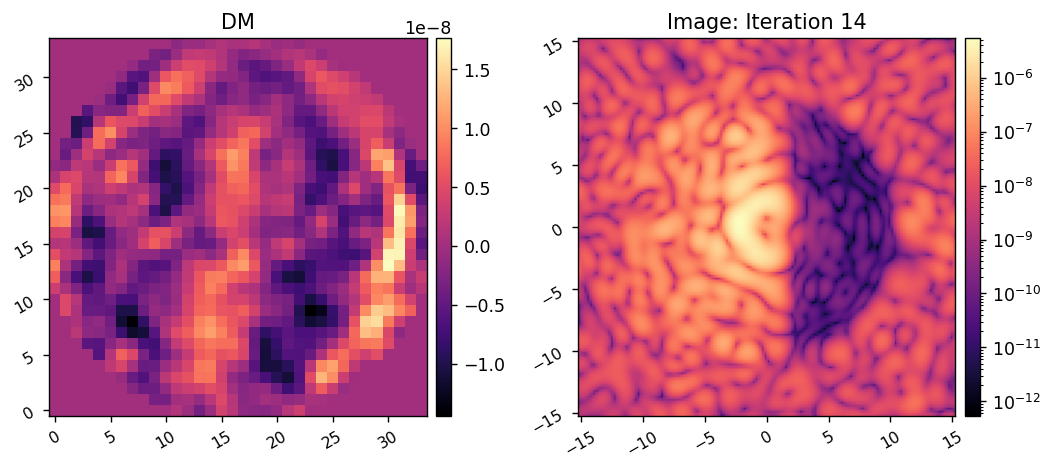

	Closed-loop iteration 15 / 30


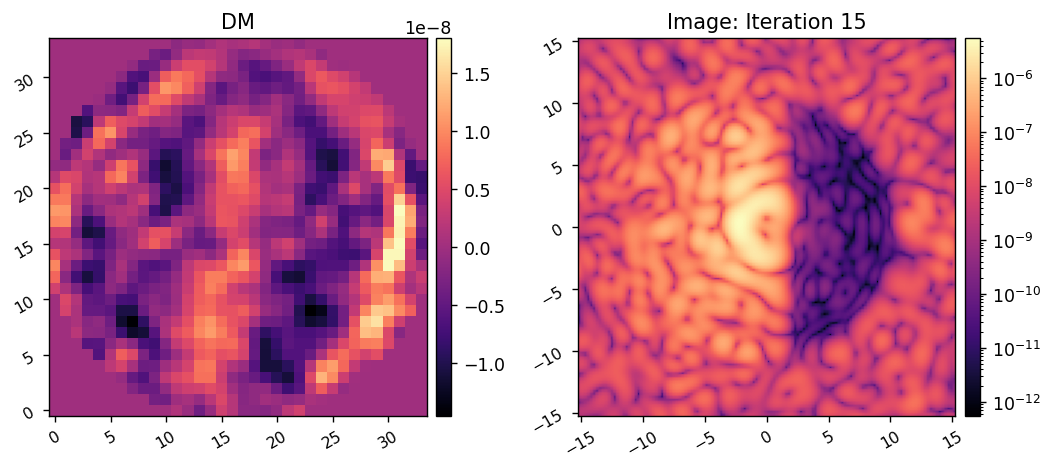

	Closed-loop iteration 16 / 30
	Computing EFC matrix via construct_control_matrix with condition value 1.00e-01
Using Weighted Least Squares 


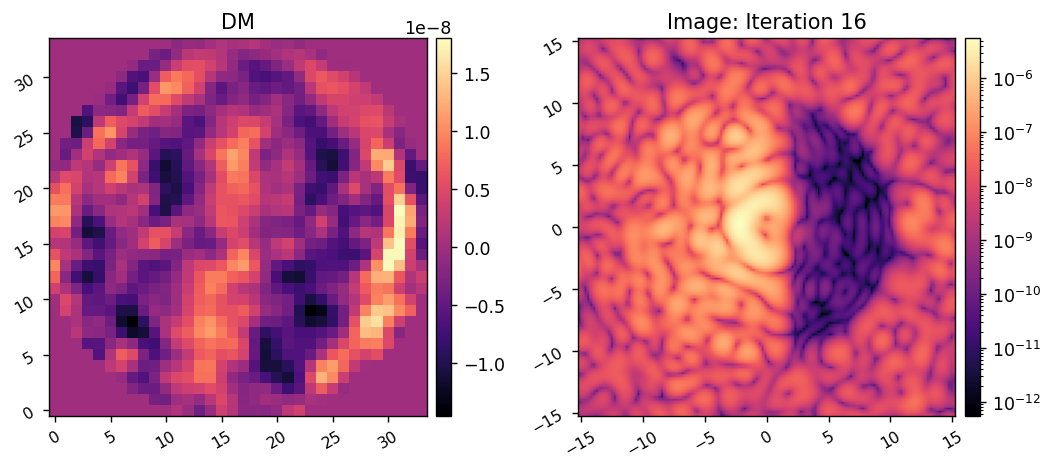

	Closed-loop iteration 17 / 30


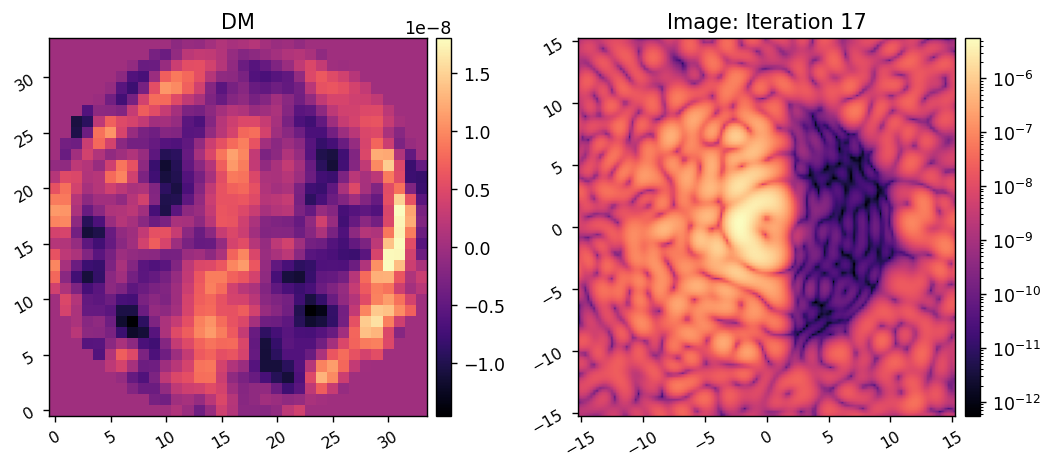

	Closed-loop iteration 18 / 30


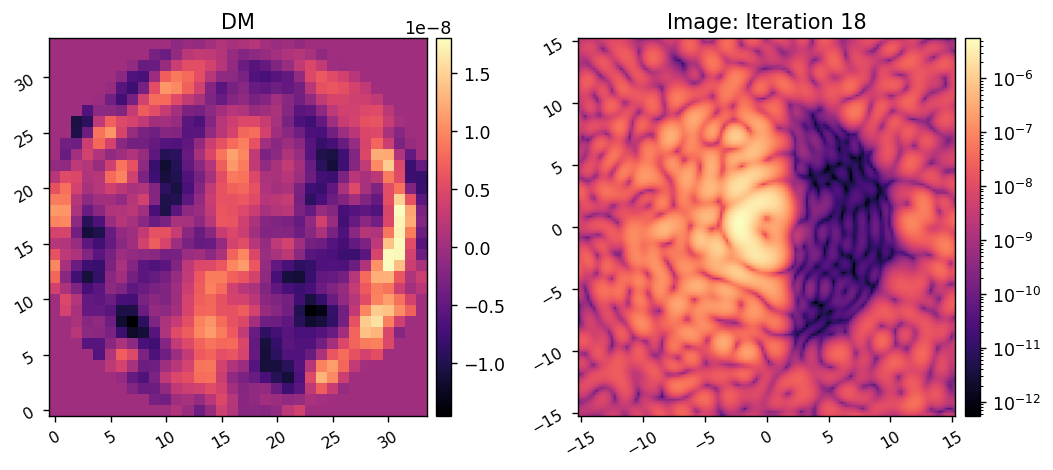

	Closed-loop iteration 19 / 30


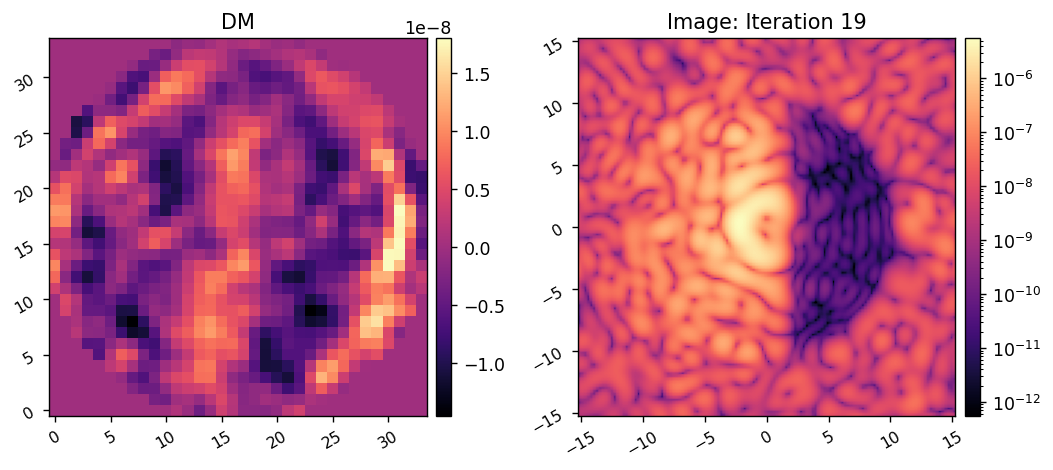

	Closed-loop iteration 20 / 30


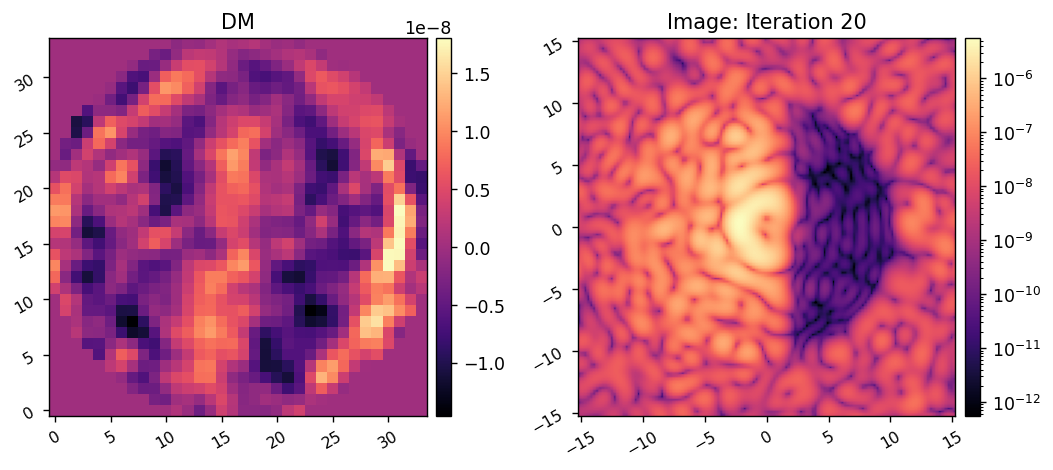

	Closed-loop iteration 21 / 30
	Computing EFC matrix via construct_control_matrix with condition value 1.00e-02
Using Weighted Least Squares 


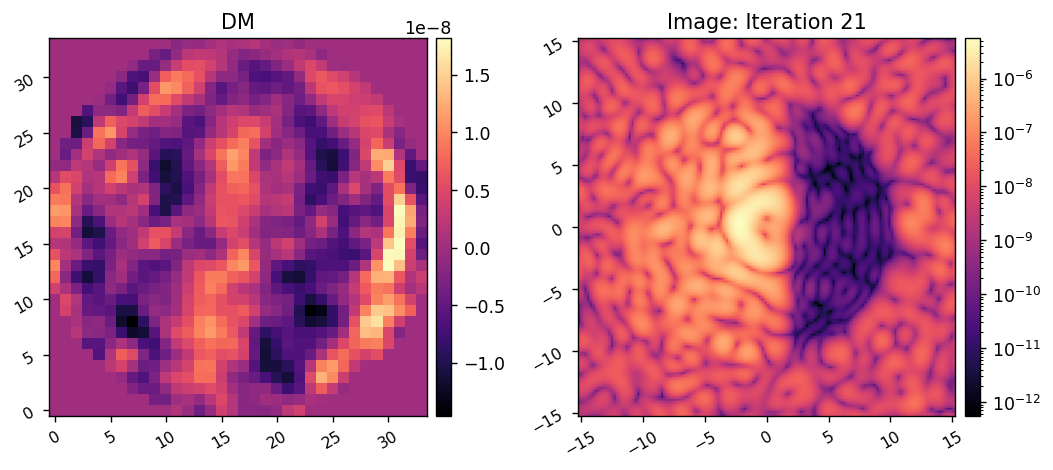

	Closed-loop iteration 22 / 30


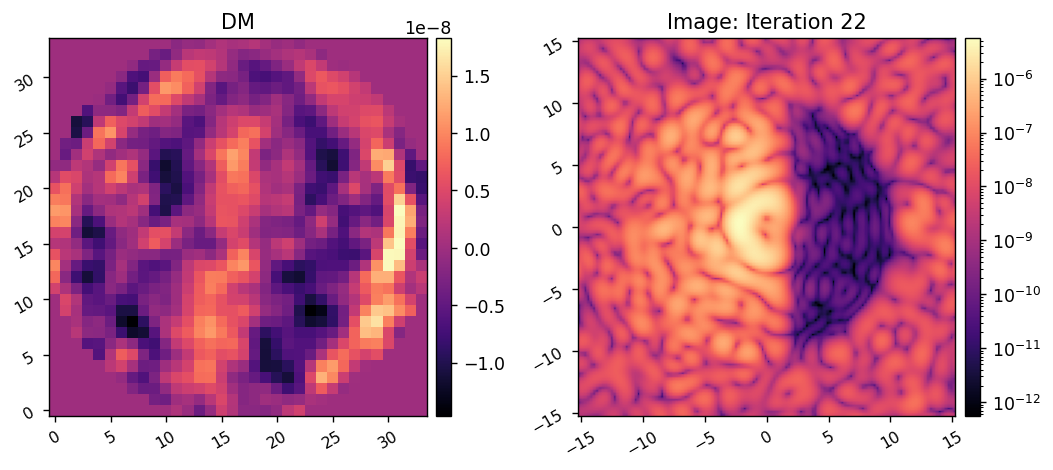

	Closed-loop iteration 23 / 30


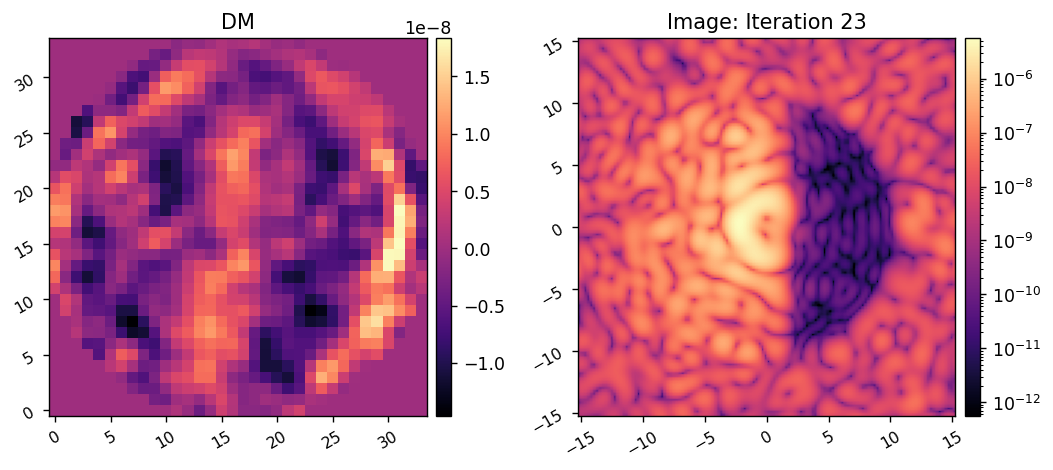

	Closed-loop iteration 24 / 30


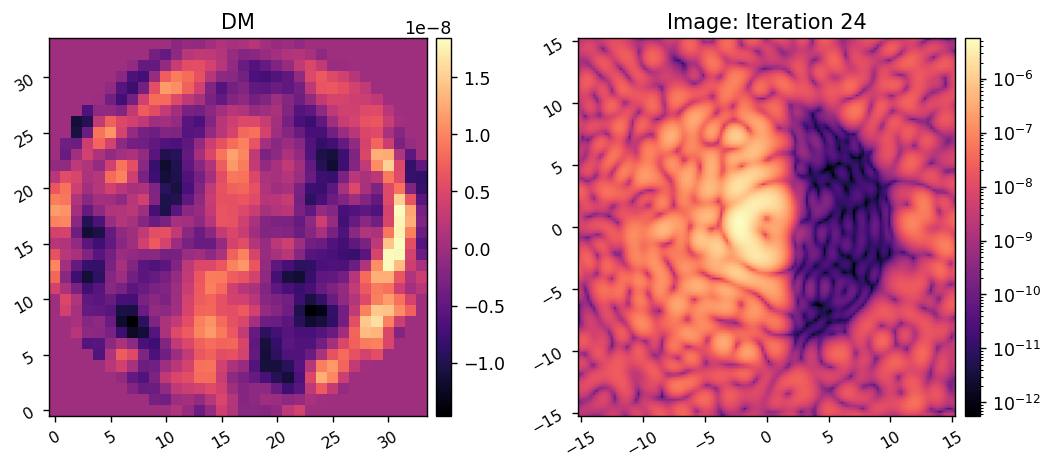

	Closed-loop iteration 25 / 30


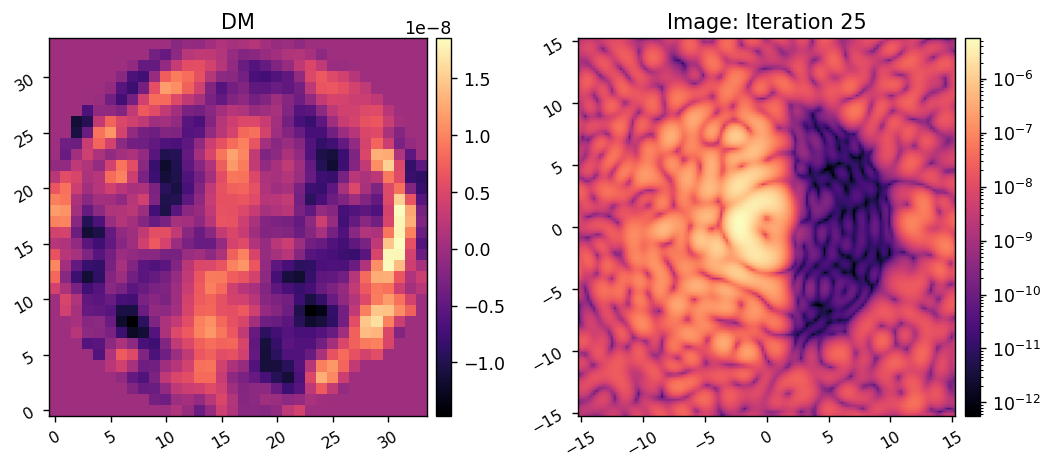

	Closed-loop iteration 26 / 30


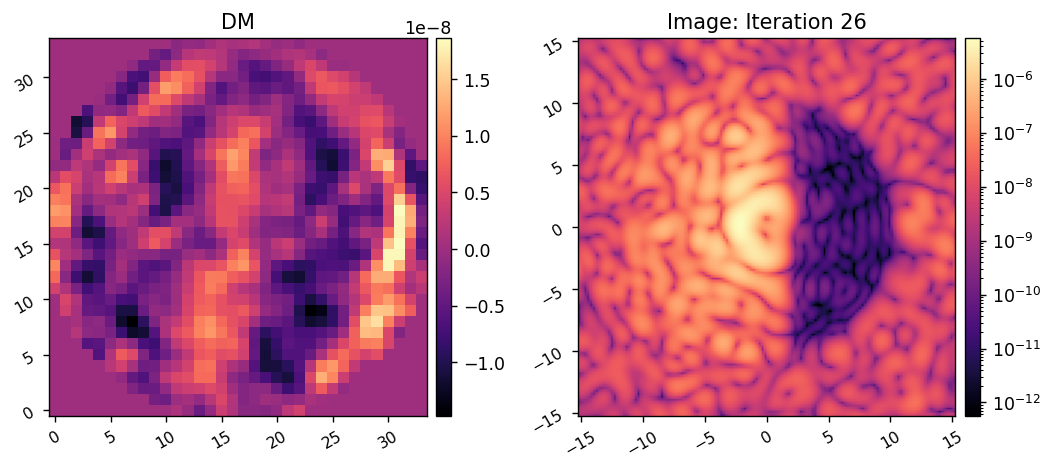

	Closed-loop iteration 27 / 30


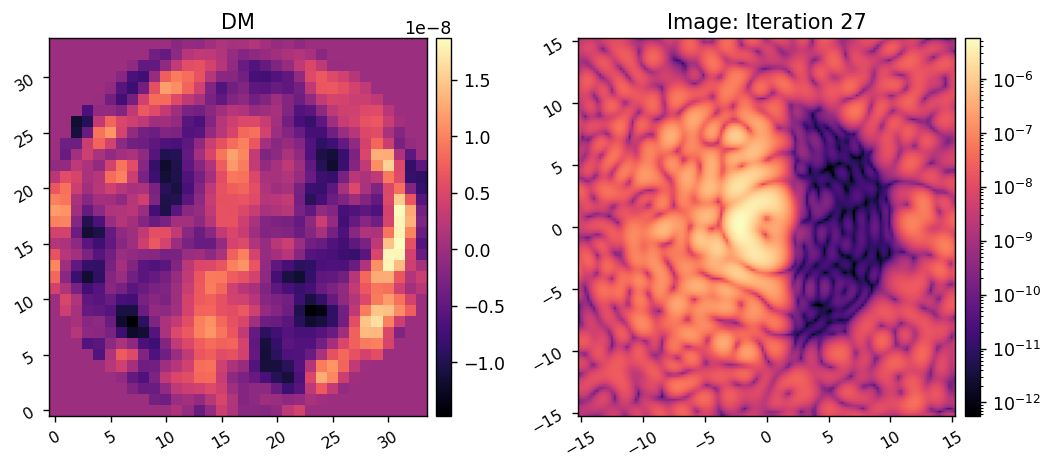

	Closed-loop iteration 28 / 30


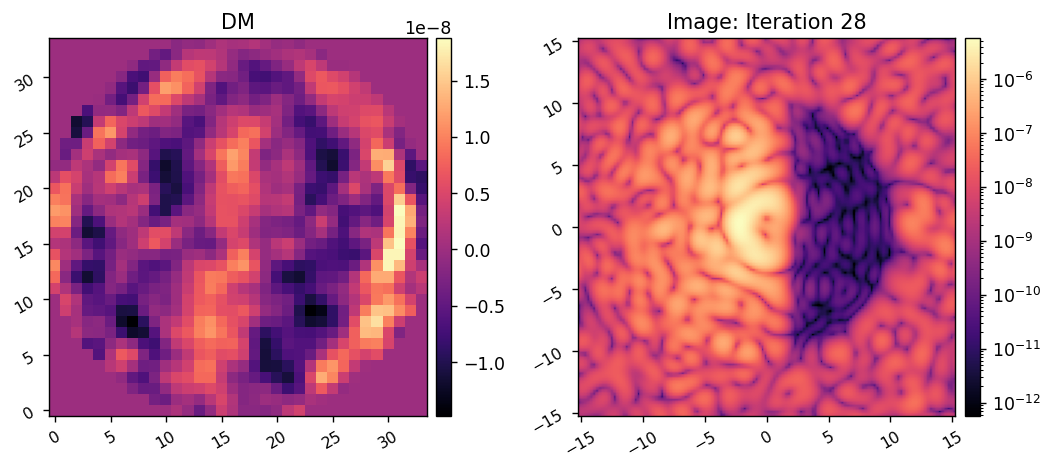

	Closed-loop iteration 29 / 30


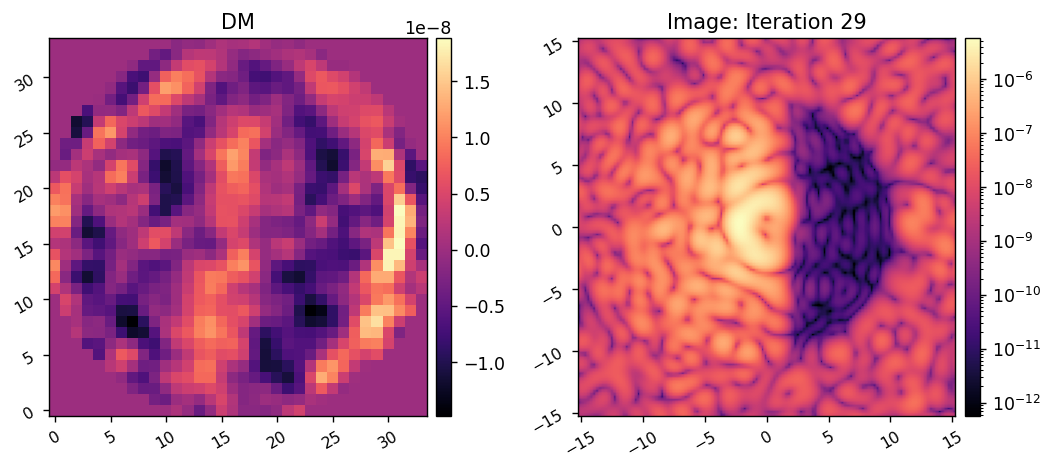

	Closed-loop iteration 30 / 30


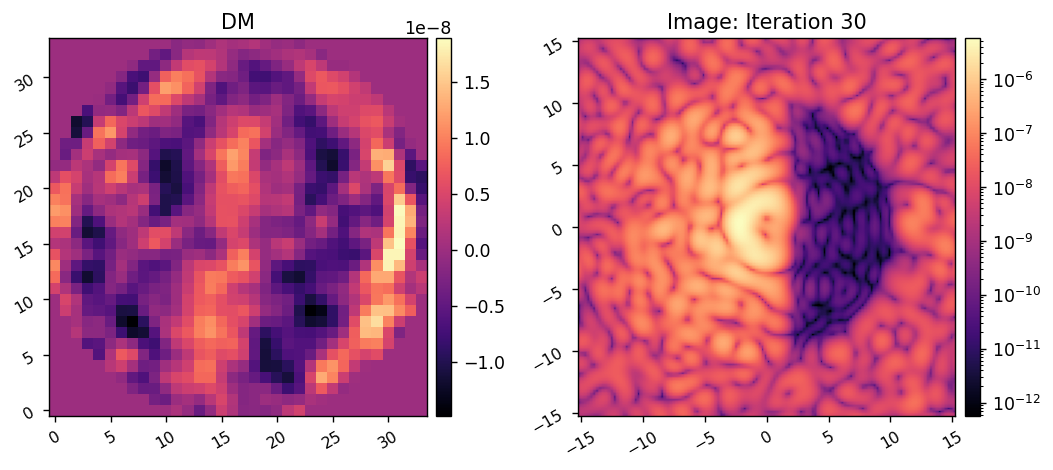

I-EFC loop completed in 30.497s.


In [48]:
reload(iefc)
cc.reset_dm()
images, dm_commands = iefc.run(cc, 
                               reg_fun,
                               reg_conds,
                               response_cube,
                               probe_modes, 
                               probe_amp, 
                               fourier_modes, 
                               weights, 
                               num_iterations=30,
                               loop_gain=0.5, 
                               leakage=0.0,
                               display_all=True)